#  Autoregressive Moving Average Model - ARMA(p,q)



We know that <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant,<br>
$y_{t-1}$ is prev series<br>
$\varepsilon_{t-1}$ is error term<br>
$\mu$ is the expectation of $y_{t}$ (often assumed to be zero),<br>
$\phi_1$ (phi-sub-one) is the AR lag coefficient, <br>
$\theta_1$ (theta-sub-one) is the MA lag coefficient,<br> $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(p,q)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} +.... +\phi_{p}y_{t-p}  + \theta_{1}\varepsilon_{t-1} + \theta_{2}\varepsilon_{t-2}+....+\theta_{q}\varepsilon_{t-q}+\varepsilon_{t}$

ARMA models expects on stationary input datasets.

For non-stationary datasets with a trend component, we go for ARIMA which i'll cover in other notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA   ## ARIMA imported, but we will use ARMA part of it only.. 

import warnings
warnings.filterwarnings('ignore')

In [2]:
def mean_absolute_percentage_error(y_true,y_pred):
    return round(np.mean(np.abs((y_true-y_pred)/y_true))*100,2)     

#### Created a timeseries dataset using sin function and random function

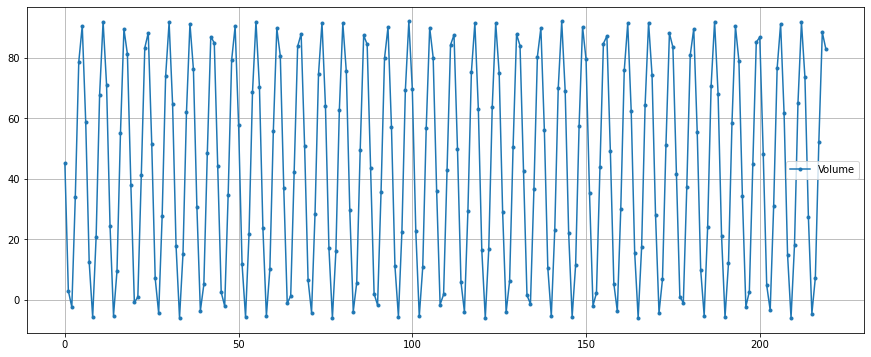

In [3]:
df = pd.DataFrame(np.sin(np.arange(-110,110))*np.random.randint(1,80)+np.random.randint(1,90))
df.columns= ['Volume']

plt.figure(figsize=(15,6))
plt.plot(df.Volume,marker='.',label='Volume')
plt.legend()
plt.grid()
plt.show()

In [4]:
class Model:
    
    def __init__(self,data=None,max_lag=None):
        self.data = data.copy()
        self.max_lag = max_lag
        self.model  = None
        self.params = {}
        
    def fit(self):
        
        # Generate Lag variables upto max lags.
        for i in range(1,self.max_lag+1):
            self.data['Lag_%d'%i] = self.data.Volume.shift(i)
        
        self.data = self.data.dropna().reset_index(drop=True)
       
        # We have all the necessary features to build a model
        self.model = LinearRegression()
     
        # Input Varible(s) - Lag variables , Predictor Variable - Original Series
        self.model.fit(self.data.drop('Volume',axis=1),self.data.Volume)
        
        self.params['Intercept'] = self.model.intercept_
        
        for i,val in enumerate(list(self.model.coef_)):
            self.params['Lag_%d'%(i+1)] =  val
        
        self.params = pd.Series(self.params).T
        
        ## Generate FittedValues
        self.fittedvalues = self.data.drop('Volume',axis=1).dot(self.model.coef_.T) + self.model.intercept_               
        
        
    def predict(self,n_preds):
        
        X = self.data.copy()
        
        for i in range(n_preds):
            
            X = X.append(pd.Series(), ignore_index=True)
            
            for j in range(1,self.max_lag+1):
                
                if j==1:
                    val  =  X.loc[len(X)-2,'Volume']
                else:
                    val =   X.loc[len(X)-2,'Lag_%d'%(j-1)]
                    
                X.loc[len(X)-1,'Lag_%d'%(j)] = val
                
                X.loc[len(X)-1,"Volume"] = X.iloc[len(X)-1,list(range(1,self.max_lag+1))].dot(self.model.coef_.T) + self.model.intercept_               
                
          
        return X[len(self.data):].reset_index(drop=True).drop('Volume',axis=1)
        
        

In [5]:
class ARMA:
    
    def __init__(self,data=None,p=None,q=None):
        self.p = p
        self.q = q
        self.data,self.resid = data.copy(),data.copy()
        self.params = {}
        
    def fit(self):
        if self.p:
            self.ar_model = Model(self.data,self.p)
            self.ar_model.fit()
            self.resid = pd.DataFrame(self.data.Volume[self.p:].values - self.ar_model.fittedvalues.values,columns=['Volume'])
        
        if self.q:
            self.ma_model = Model(self.resid,self.q)
            self.ma_model.fit()
        
    def predict(self,n_preds=20):
        # AR-part predict
        try:
            beta, intercept1 = self.ar_model.params.values[1:], self.ar_model.params.values[0]
            x1 = self.ar_model.predict(n_preds)
            ar_pred = x1@beta+intercept1
            
        except:
            ar_pred= 0 
            
        # MA-part predict  
        try:
            alpha,intercept2 = self.ma_model.params.values[1:], self.ma_model.params.values[0]
            x2 = self.ma_model.predict(n_preds)
            ma_pred = x2@alpha+intercept2
        except:
            ma_pred= 0 
            
        return ar_pred + ma_pred


    def display_model_plots(self):
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
        try:
            axes[0].plot(self.data.Volume.values[self.p:],marker='.',label='Actual',linewidth='5',color='yellow')
            axes[0].plot(self.ar_model.fittedvalues.values,color='red',marker='.',label='AR-Model Fitted Values')
            axes[0].legend()
            axes[0].grid()
        except:
            pass
        try:
            axes[1].plot(self.resid.Volume.values[self.q:],marker='.',label='Actual',linewidth='5',color='yellow')
            axes[1].plot(self.ma_model.fittedvalues.values,color='red',marker='.',label='MA-Model Fitted Values')
            axes[1].legend()
            axes[1].grid()
        except:
            pass
        
        fig.tight_layout()
        

### Split the Dataset

In [6]:
train_size = (int)(0.85 * df.shape[0]) # 85-15 split

train_df = df[:train_size].copy()
test_df = df[train_size:].reset_index(drop=True).copy()

print(train_df.shape,test_df.shape)

(187, 1) (33, 1)


### Choose p,q   - You can use Auto Correlation Function / Partial Auto Correlation Functions for this

In [7]:
max_p = 2 #  AR lags
max_q = 1 #  MA lags 

n_preds= len(test_df) + 50 # Forecast future 50 points as well

### OUR MODEL

In [8]:
model1 = ARMA(data=train_df,p=max_p,q=max_q) # This is the model created by us.
model1.fit()

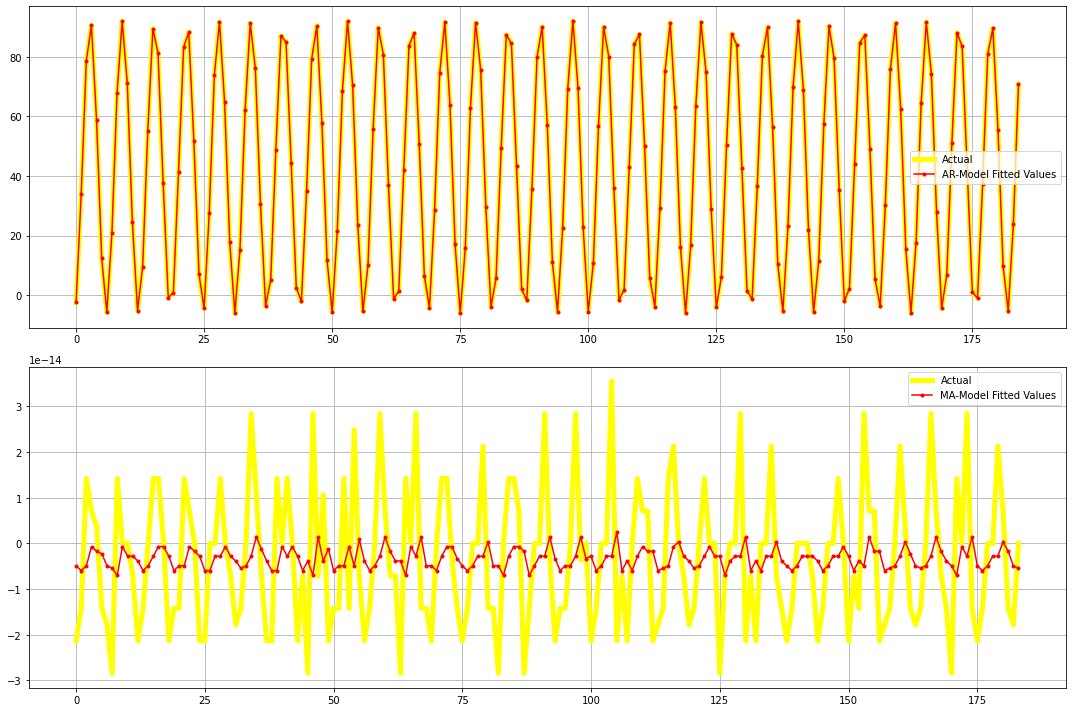

In [9]:
model1.display_model_plots()

In [10]:
pred1 = model1.predict(n_preds=n_preds) # Predictions generated by our model

### STATSMODELS MODEL

In [11]:
model_2 = ARIMA(train_df.copy(),order=(max_p,0,max_q))

In [12]:
model2= model_2.fit()

In [13]:
pred2 = model2.predict(start=len(train_df),end=len(train_df)-1+n_preds).reset_index(drop=True)#Predictions from statsmodel model

#### Plot forecast values of both models along with test data

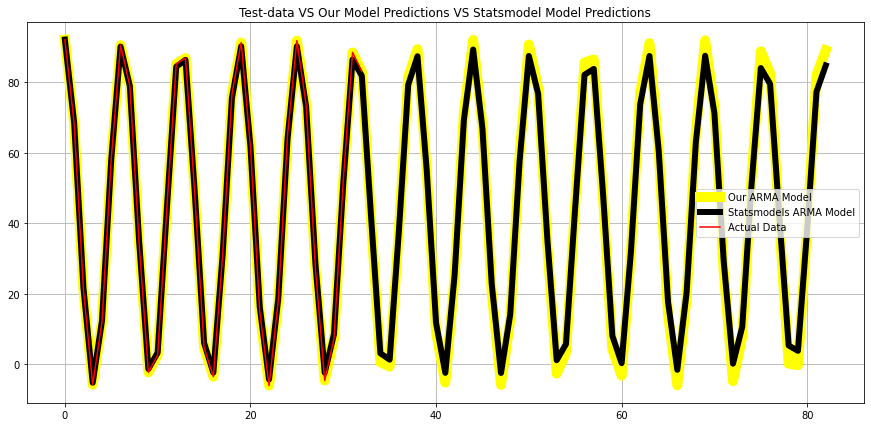

In [16]:
plt.figure(figsize=(15,7))
plt.plot(pred1,label='Our ARMA Model',color='yellow',linewidth='10')
plt.plot(pred2,label='Statsmodels ARMA Model',color='black',linewidth='6')
plt.plot(test_df.Volume,label='Actual Data',color='red')
plt.legend(loc='best')
plt.grid()
plt.title("Test-data VS Our Model Predictions VS Statsmodel Model Predictions")
plt.show()

In [15]:
print("Our ARMA Model MAPE    : ",mean_absolute_percentage_error(test_df.Volume,pred1),"%")
print("Statsmodels Model MAPE : ",mean_absolute_percentage_error(test_df.Volume,pred2),"%")

Our ARMA Model MAPE    :  0.0 %
Statsmodels Model MAPE :  8.17 %


<b>Note</b><br>
1. We have created simpler version of ARMA model from scratch. There are many more parameters which are not included in our model as our objective is to make readers understand the logic behind ARMA easily  <br>
2. ARMA model expects to be stationary. I haven't covered stationarity and other topics here. Will discuss those in other notebook.
3. We have generated a perfect MAPE score, however in reality this doesn't occur. This happened because as we used a simple stationary dataset using sin function.




### Follow me on LinkedIn: https://www.linkedin.com/in/sainath-enaganti-405346125/